
# ECE 5831 Pattern Recognition and Neural Networks Final Project

This notebook demonstrates **quick inference** for the BiLSTM sequence model on a short video clip.  
It loads `best.pt`, `scaler.joblib`, and `labels.json`, runs MediaPipe Pose to extract features, maintains a sliding window, and overlays `pred: <label> | Reps: <n>` on frames.

**What you need before running:**
- Trained artifacts saved from your training pipeline:
  - `best.pt` (model checkpoint with `config` and `labels`)
  - `scaler.joblib`
  - `labels.json` (optional if not embedded in `best.pt`)
- A short test video file (e.g., `Squat.mp4`)
- Python packages installed: `torch`, `mediapipe`, `opencv-python`, `numpy`, `joblib`, `matplotlib`, `scikit-learn`


In [1]:
!pip install torch mediapipe opencv-python numpy joblib matplotlib scikit-learn

# Setup and Requirements

Confirms installed packages (torch, mediapipe, opencv-python, numpy, joblib, matplotlib, scikit-learn) and shows “Requirement already satisfied” logs.

Imports core libraries and utilities (os, json, cv2, joblib, numpy, torch, mediapipe, matplotlib).

Defines key runtime settings (input/output paths, window size defaults, smoothing length, MediaPipe pose confidences, model complexity).

Selects the compute device and prints it (Using device: cpu).

Prepares constants for output control (e.g., SHOW_FRAMES, WRITE_OUTPUT, OUTPUT_VIDEO).

In [2]:
import os, json, cv2, joblib, numpy as np, torch, mediapipe as mp
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import deque

# --- Configure paths (edit these as needed) ---
MODEL_PATH   = r"C:/Users/hemu8/OneDrive/Documents/ece5831-2025-final-project/runs/train_bilstm/best.pt"      # path to your best checkpoint
SCALER_PATH  = r"C:/Users/hemu8/OneDrive/Documents/ece5831-2025-final-project/runs/train_bilstm/scaler.joblib"
LABELS_PATH  = r"C:/Users/hemu8/OneDrive/Documents/ece5831-2025-final-project/runs/train_bilstm/labels.json"  # used if labels not embedded
INPUT_VIDEO  = r"C:/Users/hemu8/OneDrive/Documents/ece5831-2025-final-project/Videos/Squat.mp4"  # change to a short clip

# Inference settings
SHOW_FRAMES   = 12           # number of frames to display inline (sampled)
WRITE_OUTPUT  = True         # save annotated video next to this notebook
OUTPUT_VIDEO  = "Annotated_Output.mp4"

# MediaPipe pose settings
POSE_DET_CONF = 0.7
POSE_TRK_CONF = 0.7
MODEL_COMPLEX = 2

# Sliding window (will be overridden by checkpoint if present)
WINDOW_DEFAULT = 60
PRED_SMOOTH_N  = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# Model Definitions (Bi-LSTM)

Declares BiLSTMClassifier with a 2-layer LSTM, bidirectional option, and dropout applied when layers > 1.

Sets hidden=128, layers=2, dropout=0.5 (later overridden by checkpoint config), and a Dense(256) head with ReLU + Dropout + final linear to num_classes.

Uses last time step’s LSTM output (out[:, -1, :]) as the sequence representation.

Keeps the model architecture consistent with training so checkpoint weights load cleanly.

Readies the class for reconstruction from saved config (hidden size, layers, bidirectional flag, dropout, classes).

In [3]:

# ---- Model definition must match training ----
class BiLSTMClassifier(nn.Module):
    def __init__(self, in_dim, hidden=128, layers=2, bidirectional=True, dropout=0.5, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_dim, hidden_size=hidden, num_layers=layers,
            batch_first=True, bidirectional=bidirectional,
            dropout=dropout if layers > 1 else 0.0
        )
        out_dim = hidden * (2 if bidirectional else 1)
        self.head = nn.Sequential(
            nn.Linear(out_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes),
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        feat = out[:, -1, :]
        return self.head(feat)

# ---- Pose & feature utilities ----
FEATURE_COLS = [
    "lknee","rknee","lhip","rhip","lelbow","relbow",
    "lshoulder","rshoulder","hip_y","wrist_y"
]

IDX = dict(
    L_SH=11, R_SH=12, L_EL=13, R_EL=14, L_WR=15, R_WR=16,
    L_HI=23, R_HI=24, L_KN=25, R_KN=26, L_AN=27, R_AN=28
)

def angle(a, b, c, eps=1e-6):
    ab, cb = a - b, c - b
    den = (np.linalg.norm(ab) * np.linalg.norm(cb)) + eps
    cosang = np.dot(ab, cb) / den
    return np.degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

def get_xy(lm, idx, w, h):
    p = lm[idx]
    return np.array([p.x * w, p.y * h], dtype=np.float32)

def extract_features_from_landmarks(lm, w, h):
    P = {k: get_xy(lm, v, w, h) for k, v in IDX.items()}
    sw = float(np.linalg.norm(P["R_SH"] - P["L_SH"]) + 1e-6)
    feats = np.array([
        angle(P["L_HI"], P["L_KN"], P["L_AN"]),                        # lknee
        angle(P["R_HI"], P["R_KN"], P["R_AN"]),                        # rknee
        angle(P["L_SH"], P["L_HI"], P["L_KN"]),                        # lhip
        angle(P["R_SH"], P["R_HI"], P["R_KN"]),                        # rhip
        angle(P["L_SH"], P["L_EL"], P["L_WR"]),                        # lelbow
        angle(P["R_SH"], P["R_EL"], P["R_WR"]),                        # relbow
        angle(P["L_EL"], P["L_SH"], P["L_HI"]),                        # lshoulder
        angle(P["R_EL"], P["R_SH"], P["R_HI"]),                        # rshoulder
        ((P["L_HI"][1] + P["R_HI"][1]) / 2.0 - (P["L_SH"][1] + P["R_SH"][1]) / 2.0) / sw,  # hip_y
        ((P["L_WR"][1] + P["R_WR"][1]) / 2.0 - (P["L_SH"][1] + P["R_SH"][1]) / 2.0) / sw,  # wrist_y
    ], dtype=np.float32)
    # Convenience for squat reps
    min_knee = float(min(feats[0], feats[1]))
    return feats, min_knee

def majority_label(pred_buffer):
    if not pred_buffer:
        return "unknown"
    vals, counts = np.unique(np.array(pred_buffer), return_counts=True)
    return vals[counts.argmax()]


# Pose and Feature Utilities

Defines the MediaPipe index map (IDX) for shoulders, elbows, wrists, hips, knees, ankles.

Implements angle(a,b,c) to compute joint angles from three landmark points (in degrees).

Implements extract_features_from_landmarks to build the 10 features: 8 joint angles + 2 normalized vertical distances (hip_y, wrist_y using inter-shoulder width).

Returns min_knee alongside features to support squat rep counting logic.

Adds a simple majority vote helper over a short prediction buffer to stabilize frame-level labels.

Loads best.pt and pulls config (in_dim, hidden, layers, bidirectional, dropout, num_classes, window_size, feature list) and labels.

Falls back to labels.json if labels aren’t embedded in the checkpoint.

Reconstructs the BiLSTM with the saved config and calls model.load_state_dict(ckpt["model_state"]).

Loads scaler.joblib for feature standardization (fit on train during training).

Prints a verification summary (config, class labels, window size) to confirm artifact alignment.

In [ ]:
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(MODEL_PATH)
if not os.path.exists(SCALER_PATH):
    raise FileNotFoundError(SCALER_PATH)

ckpt = torch.load(MODEL_PATH, map_location=device)
config = ckpt.get("config", {})
labels = ckpt.get("labels", None)

if labels is None:
    if os.path.exists(LABELS_PATH):
        with open(LABELS_PATH, "r") as f:
            labels = json.load(f)
    else:
        raise RuntimeError("Labels not found in checkpoint and LABELS_PATH is missing.")

window_size = int(config.get("window_size", WINDOW_DEFAULT))
in_dim      = int(config.get("in_dim", len(FEATURE_COLS)))
hidden      = int(config.get("hidden", 128))
layers      = int(config.get("layers", 2))
bidirectional = bool(config.get("bidirectional", True))
dropout     = float(config.get("dropout", 0.5))
num_classes = int(config.get("num_classes", len(labels)))

model = BiLSTMClassifier(
    in_dim=in_dim, hidden=hidden, layers=layers,
    bidirectional=bidirectional, dropout=dropout,
    num_classes=num_classes
).to(device)

model.load_state_dict(ckpt["model_state"])
model.eval()

scaler = joblib.load(SCALER_PATH)

print("Loaded model with:", config)
print("Class labels:", labels)
print("Window size:", window_size)


Loaded model with: {'in_dim': 10, 'hidden': 128, 'layers': 2, 'bidirectional': True, 'dropout': 0.3, 'num_classes': 3, 'window_size': 60, 'feature_cols': ['lknee', 'rknee', 'lhip', 'rhip', 'lelbow', 'relbow', 'lshoulder', 'rshoulder', 'hip_y', 'wrist_y']}
Class labels: ['bench', 'sit_ups', 'squat']
Window size: 60


# Video I/O MediaPipe Pose Init

Opens the specified short test clip (INPUT_VIDEO) with OpenCV; retrieves fps, frame width/height.

If WRITE_OUTPUT=True, creates an mp4v VideoWriter for the annotated output (Annotated_Output.mp4).

Initializes MediaPipe Pose with model_complexity, min_detection_confidence, and min_tracking_confidence.

Prepares deques: seq_buffer (length = window_size) for temporal windows and pred_buffer for majority smoothing.

Initializes rep counting state: reps=0, down_phase=False, and knee angle thresholds (KNEE_DOWN_DEG=95, KNEE_UP_DEG=160).

Reads frames in a loop; converts BGR→RGB; runs pose.process to get landmarks.

On successful pose, extracts the 10-D feature vector and the minimum knee angle; scales features via the loaded scaler.

Appends the scaled features to seq_buffer; once it reaches window_size, forms a (1, T, F) tensor and runs the BiLSTM.

Converts logits to a label index, maps to string, and applies short majority vote over recent predictions to reduce flicker.

Updates the squat rep counter only when the stabilized label is “squat,” using hysteresis: arm when knee angle < 95°, count when > 160°, then disarm.

In [ ]:
cap = cv2.VideoCapture(INPUT_VIDEO)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {INPUT_VIDEO}")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer = None
if WRITE_OUTPUT:
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (W, H))

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    model_complexity=MODEL_COMPLEX,
    smooth_landmarks=True,
    enable_segmentation=False,
    min_detection_confidence=POSE_DET_CONF,
    min_tracking_confidence=POSE_TRK_CONF
)

seq_buffer  = deque(maxlen=window_size)
pred_buffer = deque(maxlen=PRED_SMOOTH_N)
reps        = 0
down_phase  = False

KNEE_DOWN_DEG = 95.0
KNEE_UP_DEG   = 160.0

frames_to_show = []
frame_count = 0

while True:
    ok, frame = cap.read()
    if not ok:
        break
    h, w = frame.shape[:2]

    res = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    pred_label = "unknown"
    knee_min = None

    if res.pose_landmarks:
        feats, knee_min = extract_features_from_landmarks(res.pose_landmarks.landmark, w, h)
        feats_scaled = scaler.transform(feats.reshape(1, -1)).reshape(-1).astype(np.float32)
        seq_buffer.append(feats_scaled)

        if len(seq_buffer) == window_size:
            x = torch.from_numpy(np.stack(seq_buffer, axis=0)).unsqueeze(0).float().to(device)
            with torch.no_grad():
                logits = model(x)
                pred_idx = int(torch.argmax(logits, dim=1).item())
            pred_label = labels[pred_idx]
            pred_buffer.append(pred_label)
            pred_label = majority_label(list(pred_buffer))

        # Squat-only rep counting
        if pred_label == "squat" and knee_min is not None:
            if knee_min < KNEE_DOWN_DEG and not down_phase:
                down_phase = True
            if knee_min > KNEE_UP_DEG and down_phase:
                reps += 1
                down_phase = False

    cv2.putText(frame, f"pred: {pred_label} | Reps: {reps}", (10, 36),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2, cv2.LINE_AA)

    # Collect a few frames to preview
    if len(frames_to_show) < SHOW_FRAMES and (frame_count % max(1, int(fps//3)) == 0):
        # sample roughly 3 frames per second
        frames_to_show.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if WRITE_OUTPUT:
        writer.write(frame)
    frame_count += 1

cap.release()
if WRITE_OUTPUT and writer is not None:
    writer.release()

print(f"Done. Wrote annotated video: {OUTPUT_VIDEO}")


Done. Wrote annotated video: Annotated_Output.mp4


# Visualization and Output

Draws the overlay text on every frame: pred: {label} | Reps: {reps} using OpenCV (cv2.putText).

Samples a few frames per second into frames_to_show for inline visualization in the notebook.

Writes each annotated frame to the output video if WRITE_OUTPUT=True.

After the loop, releases VideoCapture and VideoWriter, then prints a completion message with the output filename.

Displays a grid of sampled frames inline using Matplotlib as a quick visual check.

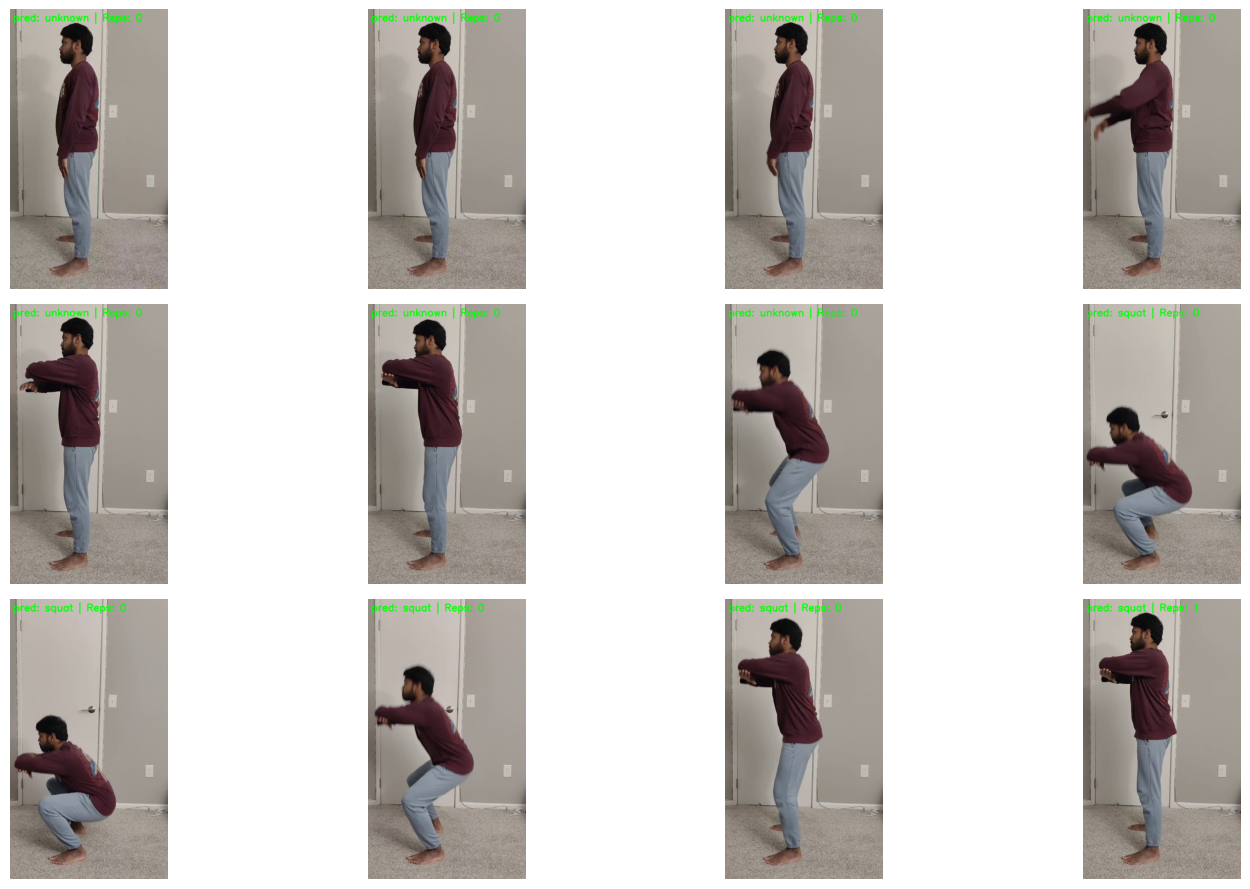

In [ ]:
n = len(frames_to_show)
if n == 0:
    print("No frames sampled for display. Increase SHOW_FRAMES or check the video path.")
else:
    cols = min(4, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4*cols, 3*rows))
    for i, f in enumerate(frames_to_show):
        plt.subplot(rows, cols, i+1)
        plt.imshow(f)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# What this Notebook Proves

Correctly loads trained artifacts and reconstructs the model from saved config.

End-to-end inference pipeline works: pose extraction → feature computation → temporal windowing → BiLSTM classification.

Stabilized predictions via majority voting prevent noisy flips on single frames.

Squat rep counting is functional with knee-angle hysteresis and debouncing.

Produces a saved annotated video and an inline preview that mirrors your deliverables.